<h1> Welcome to the 1<sup>st</sup> theory part for PE1!</h1>

The final goal for Physics Experiments as a whole is being able to perform and analyze any experiment that incoroprates feedback and noise reduction. To be able to do so you will first need to create a spectrum analyzer that can analyze various experimental systems automatically. That will be your goal for Physics Experiments 1. This will mostly be done by making use of the programming language Python.

Today you will begin your path towards that and focus on two things:
<ul>
    <li> You will learn how to read and write signals onto the MyDAQ using python.
    <li> You will use Objected Oriented Programming (OOP) to create an easy system for yourself to get different tasks done on the MyDAQ.
</ul>

<h2> Controlling the MyDAQ using python </h2>

Last year, in Experimentele Natuurkunde, you have used the MyDAQ a few times to read out data using a program made by us. It would however be useful if you could get and analyse the data simultaneously using python. Furthermore, the MyDAQ can also be used to generate signals, which we will further refer to as writing data. The MyDAQ is therefore a combination of an oscilloscope with a function generator. Hence, you can use it to automatically evaluate transfer functions of various electronic systems. After this session you will be able to communicate with any apparatus you may encounter in a lab.

In [2]:
# Installs some basic functions

%pylab inline

import nidaqmx as dx
import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


<h3>1.1 Writing to the MyDAQ</h3>

<h4>1.1A: Writing 1 sample to 1 channel</h4>
We will start easy. Connect an oscilloscope to the output (AO0) to validate/prove that what you intend to write as output to the MyDAQ actually is the intended signal. In the following cell, the code is shown for writing a constant voltage to the output of the MyDAQ.

It is hard to notice a constant voltage output on the oscilloscope without some tweaking. If you have any difficulty, you could use a DMM to verify that the code works.

In [10]:
"""
To write data (= voltage(s)) to the MyDAQ, we use the package NiDAQmx.
We will first work through writing data
"""
# We start a task to write a single output
with dx.Task() as writeTask:
    
    """Now writeTask is everything we need to worry about"""
    # We need to tell the computer where to write to. 
    #Of course, this will be the MyDAQ and to the output AO0.
    writeTask.ao_channels.add_ao_voltage_chan('myDAQ1/ao0')     # MyDAQ2 ipo 1 everywhere
    
    """
    Let's first try to just write a single voltage. Connect a scope to 
    the output (AO0) of the MyDAQ and connect the MyDAQ to the computer
    """
    
    # There are two ways to write,
    
    #1) We define a write task, and start it. 
    myVoltage = 0
    writeTask.write(myVoltage)
    writeTask.start()
    
    #Remember that a task always needs to be closed!
    writeTask.stop()
    
    #2) In one go
    writeTask.write(myVoltage, auto_start=True)
    
    """
    So, as you can see we have just used the writeTask.write() function 
    to write a single output to the MyDAQ If everything is OK you 
    should now see this voltage on the scope?
    """
    
    writeTask.stop()

<h4>1.1B: Writing N samples to 1 channel with timing</h4>
Instead of writing one voltage level, you can also write out a sequence of voltage samples. The MyDAQ will then write out these voltage levels in descrete steps with a certain predefined sample rate (The number of items written to the MyDAQ per second). Using this, you can create any arbitrary waveform, for example a stair function, as used in the code below. In the following cell, the code is shown for writing out a sequence to the MyDAQ.

<b>Play around with the parameters and try to understand what happens.</b>

In [15]:
#Again, we start a task like before
with dx.Task() as writeTask:
    
    # Add your output channel to WriteTask as before.
    writeTask.ao_channels.add_ao_voltage_chan('myDAQ1/ao0')
    
    # We define a sample rate
    rate           = 500 # samples / sec
    
    # Number of samples to write
    samps_per_chan = 5000                       # long not needed anymore
    
    # Question: How long will the signal last?
    
    writeTask.timing.cfg_samp_clk_timing(rate,sample_mode = dx.constants.AcquisitionType.FINITE, \
                                         samps_per_chan=samps_per_chan)    
    """The sample_mode is set to FINITE. 
    This means that the MyDAQ expects a FINITE number
    of samples to write, e.g. samps_per_chan.
    
    Sample mode is either dx.constants.AcquisitionType.FINITE or 
    dx.constants.AcquisitionType.CONTINUOUS.
    
    Samps_per_chan specifies the number of samples to generate if in 
    FINITE, or if CONTINUOUS this specifies the buffer size.
    # make sure samps_per_chan is of integer type long (by using long())
    """
    
    # Now everything is set and we can start to write data
    
    # First define the sequence you want to write to the MyDAQ
    stairs = [0.0,0.0,1.1, 2.2, 3.3, 4.4, 5.5,6,8,9]
    
    # Then you can simply write it to the MyDAQ like before
    writeTask.write(stairs, auto_start=True)
    
    """This data is now stored on the MyDAQ to be written to the output. 
    This takes however a finite amount of time, since we are writing 
    with finite frequency. We thus wait before closing the connection"""
    time.sleep(samps_per_chan/rate + 0.001)
    writeTask.stop()

<h4>1.1C: Writing N samples to N channels</h4>
As you might have seen, the MyDAQ has multiple output channels. You can also write to these channels simultaneously. In the cell below, the code is shown for doing so.

<b>Play around with the parameters and try to understand what happens.</b>

In [18]:
#create a task
with dx.Task() as writeTask: 
    
    #First, we add both channels to writeTask
    writeTask.ao_channels.add_ao_voltage_chan('myDAQ1/ao0')
    writeTask.ao_channels.add_ao_voltage_chan('myDAQ1/ao1')
    
    # We define a rate
    rate           = 500 # samples / sec
    
    # number of samples to write
    samps_per_chan = 5000
    
    writeTask.timing.cfg_samp_clk_timing(rate,sample_mode = dx.constants.AcquisitionType.FINITE, \
                                         samps_per_chan=samps_per_chan)  
    
    """Everything is set. Instead of passing a list or array to the 
    write function, we now need to pass two of them. One per channel"""
    
    # This writing can be done using lists:
    channel1data = [1.1, 2.2, 3.3]
    channel2data = [1.1, 2.2, 4.4]
    
    # 2 channels , 3 samples per channel
    writeTask.write([channel1data, channel2data], auto_start=True)
    
    time.sleep(samps_per_chan/rate + 0.001)
    
    writeTask.stop()

<h3>1.2 Reading from the MyDAQ</h3>
<h4>1.2A: Reading from one of the inputs of the MyDAQ</h4>
Now we will learn how to read a signal that is delivered to the MyDAQ.
Try to extend this program such that you get the correct time values. Connect a function generator to an input of the MyDAQ to prove your results.

0.07628242345526814


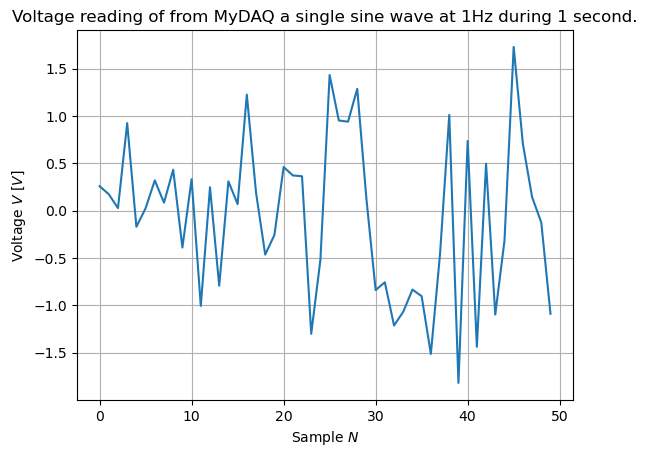

In [3]:
"""Exactly the same procedures hold for reading in data. Now that we have 
discusses writing to excessivly, you can do the reading part yourself"""

with dx.Task() as readTask:
    #Add the correct channel to readTask
    readTask.ai_channels.add_ai_voltage_chan('myDAQ1/ai0')
    
    #Again define the clock settings
    samps_per_chan = 50 + 1
    rate = 50
    
    readTask.timing.cfg_samp_clk_timing(rate,sample_mode = dx.constants.AcquisitionType.FINITE, samps_per_chan=samps_per_chan)
     
    #1 Channel 1 Sample read:
    data=readTask.read()
    print(data)
    
    #1 Channel N Samples read:
    data=readTask.read(number_of_samples_per_channel = samps_per_chan - 1)
    #print(data)
    plt.figure(1)
    plt.plot(data)
    plt.xlabel("Sample $N$")
    plt.ylabel("Voltage $V$ [$V$]")
    plt.grid()
    plt.title("Voltage reading of from MyDAQ a single sine wave at 1Hz during 1 second.")
    plt.savefig("first_read.pdf")
    plt.show()

<h4>1.2B: Reading from multiple inputs of the MyDAQ</h4>
You can also read from multiple inputs of the MyDAQ simultaneously.

[1.021911676536547, 1.021911676536547]


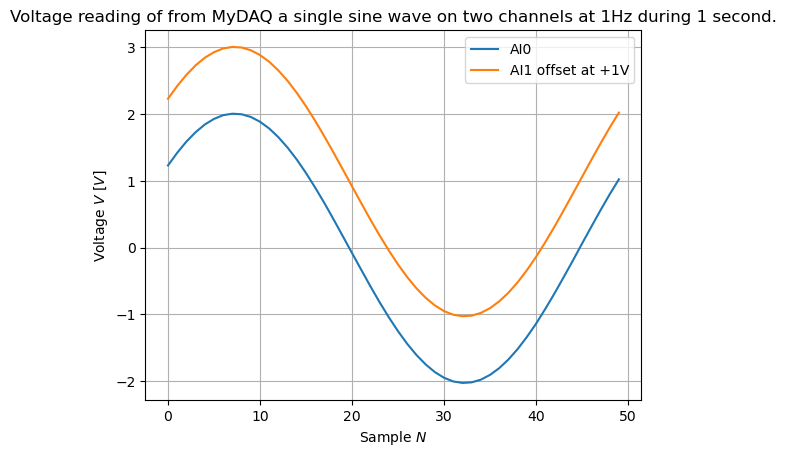

In [49]:
with dx.Task() as readTask:
    #Now we will add two channels to the readTask
    readTask.ai_channels.add_ai_voltage_chan('myDAQ1/ai0')
    readTask.ai_channels.add_ai_voltage_chan('myDAQ1/ai1')
    
    #Again define the clock settings
    samps_per_chan = 50 + 1
    rate = 50
    
    readTask.timing.cfg_samp_clk_timing(rate,sample_mode = dx.constants.AcquisitionType.FINITE, samps_per_chan=samps_per_chan)
     
    #2 Channel 1 Sample read:
    data=readTask.read()
    print(data)
    
    #2 Channel N Samples read:
    data=readTask.read(number_of_samples_per_channel = samps_per_chan - 1)
    
    #print(data)
    plt.figure(1)
    plt.plot(data[0], label='AI0') #Data from the first channel
    plt.plot(np.array(data[1]) + 1, label='AI1 offset at +1V') #Data from the second channel
    plt.xlabel("Sample $N$")
    plt.ylabel("Voltage $V$ [$V$]")
    plt.grid()
    plt.title("Voltage reading of from MyDAQ a single sine wave on two channels at 1Hz during 1 second.")
    plt.legend()
    plt.savefig("double_read.pdf")
    plt.show()

<h3>1.3 Writing to & Reading from the MyDAQ</h3>

<h4>To do: Combine writing to and reading from the MyDAQ</h4>
Combine writing to and reading from the MyDAQ and prove that your program is working as it is supposed to.

<b> Tip: Use a BNC T-Adapter to read a signal on the MyDAQ and on the Oscilloscope simultaneously.</b>

In [80]:
def sinewave(steps, ammount=1, amplitude=1, offset=0):
    x = np.linspace(0, 2 * np.pi, steps)
    return offset + amplitude * np.sin(x*ammount)

[2.396499392169062, 2.5167636283440515, 2.6324773258529603, 2.7436404846957885, 2.851878297253279, 2.9565406865731347, 3.056327498750761, 3.1528639261669014, 3.242249507107772, 3.3290347802394535, 3.40996936080046, 3.487003479647683, 3.5591620213526767, 3.625794908963144, 3.687227180955233, 3.742808760376647, 3.7938398011319805, 3.8393451877927873, 3.8793249203590676, 3.9137789988308214, 3.9423823847319, 3.965460116538452, 3.9830121942504775, 3.995363656344125, 4.001539387390949, 4.001539387390949, 3.9966638102487195, 3.9862625790119637, 3.968710501299938, 3.9469329233979806, 3.9186545759730507, 3.88582568988204, 3.8461709957919084, 3.8022908015118446, 3.7519098377088085, 3.6963282582873944, 3.6365211786760483, 3.5705383680178784, 3.4993549417413305, 3.4232959383225534, 3.342361357761547, 3.2572012770106085, 3.166840580641292, 3.072579422558192, 2.9737677258090116, 2.8687802980130073, 2.762817754788557, 2.6513295574695803, 2.5356158599606715, 2.4173018546425737, 2.294762349134544, 2.16

TypeError: 'Text' object is not callable

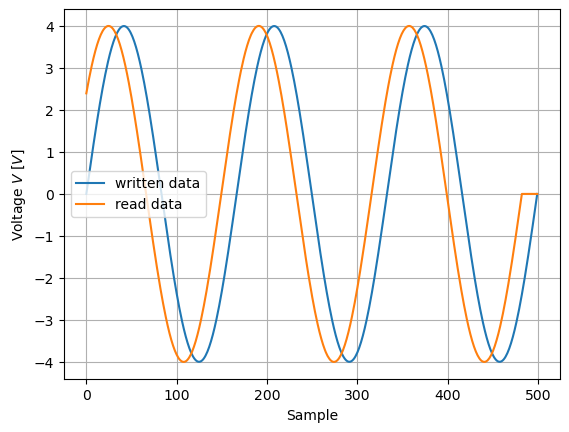

In [82]:
# To combine reading and writing you will need to put the two together.
with dx.Task('AOTask') as writeTask, dx.Task('AITask') as readTask:
    # Your code here:
    rate = 500
    samps = 500
    
    readTask.ai_channels.add_ai_voltage_chan('myDAQ1/ai0')
    writeTask.ao_channels.add_ao_voltage_chan('myDAQ1/ao0')

    readTask.timing.cfg_samp_clk_timing(rate,sample_mode = dx.constants.AcquisitionType.FINITE, samps_per_chan=samps)
    writeTask.timing.cfg_samp_clk_timing(rate,sample_mode = dx.constants.AcquisitionType.FINITE, \
                                         samps_per_chan=samps)
    
    write_data = sinewave(samps, 3, 4, 0)

    writeTask.write(write_data, auto_start=True)
    read_data=readTask.read(number_of_samples_per_channel = samps)
    print(read_data)
    writeTask.stop()

    fig, ax = plt.subplots()
    ax.plot(write_data, label="written data")
    ax.plot(read_data, label="read data")
    ax.grid()
    ax.set_xlabel("Sample")
    ax.set_ylabel("Voltage $V$ [$V$]")
    ax.legend()
    ax.title("Data written and read back from MyDAQ over 1s")
    plt.show()

<h3>Combining the MyDAQ with OOP </h3>
To avoid repetition in your code and to make reading and writing from and to the MyDAQ easier, you can create an object in which you define your functions.

(If you are not familiar with OOP anymore, you can do some exercises in the Jupyter Notebook on OOP.)

Create an object with which you can run the following code. Try to make some useful function which you think you will use in the future, for example a function to output a sine wave with a certain frequency and amplitude.

<b>Read the practical syllabus carefully before you start working on your MyDAQ class. Make sure that your code does everything which is stated in the syllabus.</b> 

In [ ]:
class MyDAQ():
    """A class to controll the MyDAQ"""
    def __init__(self):
        self.finite = dx.constants.AcquisitionType.FINITE
        pass

    def readWrite(self, write_data, rate=500, samps=None, read_channel='ai0',
                  write_channel='ao0'):
        """Reads and writes data to the MyDAQ.
        
        parameters
        ----------
        write_data : array
            The voltage data to write to the MyDAQ
        rate : int
            The sample rate in Hz
        samps : int
            The number of samples to read and write. If None, all of write_data
            is written, and the length of write_data is read. If not None, the 
            length of write_data is written and repeated for the ammount of
            samples requested.
        read_channel : str
            The channel to read from
        write_channel : str
            The channel to write to

        returns
        -------
        list
            The data read from the MyDAQ
        """
        with dx.Task('AOTask') as writeTask, dx.Task('AITask') as readTask:
            if samps is None:
                samps = len(write_data)
            readTask.ai_channels.add_ai_voltage_chan(f'myDAQ1/{read_channel}')
            writeTask.ao_channels.add_ao_voltage_chan(f'myDAQ1/{write_channel}')

            readTask.timing.cfg_samp_clk_timing(rate, sample_mode=self.finite,
                                                samps_per_chan=samps)
            writeTask.timing.cfg_samp_clk_timing(rate, sample_mode=self.finite,
                                                samps_per_chan=samps)

            writeTask.write(write_data, auto_start=True)
            read_data=readTask.read(number_of_samples_per_channel = samps)
            print(read_data)
            writeTask.stop()
            return read_data
    
    def read(self, rate=500, samps=500, channel='ai0'):
        """Reads data from the MyDAQ.
        
        parameters
        ----------
        rate : int
            The sample rate in Hz
        samps : int
            The number of samples to read
        channel : str
            The channel to read from
        
        returns
        -------
        list
            The data read from the MyDAQ
        """
        with dx.task() as readTask:
            readTask.ai_channels.add_ai_voltage_chan(f'myDAQ1/{channel}')

            readTask.timing.cfg_samp_clk_timing(rate, sample_mode=self.finite,
                                                samps_per_chan=samps)

            read_data=readTask.read(number_of_samples_per_channel = samps)
            return read_data
        
    def write(self, write_data, rate=500, samps=None, channel='ao0'):
        """Writes data to the MyDAQ.
        
        parameters
        ----------
        write_data : array
            The voltage data to write to the MyDAQ
        rate : int
            The sample rate in Hz
        samps : int
            The number of samples to write. If None, all of write_data
            is written. If not None, the length of write_data is written and 
            repeated for the ammount of samples requested.
        channel : str
            The channel to write to
        """
        with dx.Task() as writeTask:
            if samps is None:
                samps = len(write_data)
            writeTask.ao_channels.add_ao_voltage_chan(f'myDAQ1/{channel}')
            writeTask.timing.cfg_samp_clk_timing(rate, sample_mode = dx.constants.AcquisitionType.FINITE, samps_per_chan=samps)
            writeTask.write(write_data, auto_start=True)
            time.sleep(samps/rate + 0.001)
            writeTask.stop()


In [ ]:
"""
This is only an example of some functions that might be useful for you.
You can create/name them of course as you wish.
"""

myDAQ = MyDAQ()
myDAQ.write(array, rate)
voltages = myDAQ.getVoltData()
times = myDAQ.getTimeData()